# On "[Learning Representatio by back-propagation errors](https://www.nature.com/articles/323533a0)"

We will build and train a simple feedforward neural network using PyTorch to solve a binary sequence classification problem. Specifically, we will classify a sequence of 6 binary values as **symmetric** or **non-symmetric**. The network will learn an internal representation of symmetry through back-propagation.

## Problem Setup: Binary Sequence Symmetry Classification

### Task Description

- **Input:** A sequence of 6 binary values, e.g., `[0, 0, 1, 1, 0, 0]`.
- **Output:** A label of `1` if the sequence is symmetric and `0` otherwise.

For example, the sequence `[1, 0, 1, 1, 0, 1]` has mirror symmetry, whereas `[1, 0, 0, 1, 0, 1]` does not have such a symmetry.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Dataset Generation

We generate a dataset of binary sequences of length 6. To ensure a balanced dataset:

- **Symmetric Sequences:** We generate these by randomly choosing the first half of the sequence and mirroring it.
- **Non-Symmetric Sequences:** We generate random sequences and reject the ones that are symmetric.

Each example is labeled `1` if it is symmetric and `0` otherwise.

In [ ]:
def generate_symmetric_sequence(length=6):
    # Generate the first half randomly
    half = np.random.randint(0, 10, size=length // 2).tolist()
    # Mirror the half to create a symmetric sequence
    return half + half[::-1]


def generate_non_symmetric_sequence(length=10):
    # Keep generating until a non-symmetric sequence is found
    while True:
        seq = np.random.randint(0, 10, size=length).tolist()
        if seq != seq[::-1]:
            return seq

def create_dataset(num_samples=1000, length=6):
    X = []
    y = []
    for _ in range(num_samples // 2):
        X.append(generate_symmetric_sequence(length))
        y.append(1)
    for _ in range(num_samples // 2):
        X.append(generate_non_symmetric_sequence(length))
        y.append(0)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)

# Create the dataset
X, y = create_dataset(num_samples=1000, length=6)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y)

print('Dataset shape:', X_tensor.shape, y_tensor.shape)

Dataset shape: torch.Size([1000, 6]) torch.Size([1000, 1])


## Network Design

We will build a simple feedforward neural network with one hidden layer. The architecture is as follows:

- **Input Layer:** 6 neurons (one per binary digit).
- **Hidden Layer:** 1 neurons with Sigmoid activation.
- **Output Layer:** 1 neuron with Sigmoid activation to produce a probability for the binary classification.

The network is implemented as a subclass of `nn.Module`.

In [ ]:
class SymmetryNet(nn.Module):
    def __init__(self, input_size=6, hidden_size=1):
        super(SymmetryNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.Sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.Sigmoid(out)
        out = self.layer2(out)
        out = self.sigmoid(out)
        return out

# Instantiate the model
model = SymmetryNet()

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, -0.3, 0.3)
        if m.bias is not None:
            nn.init.uniform_(m.bias, -0.3, 0.3)

# Apply the custom weight initialization to the model
model.apply(init_weights)

print(model)

SymmetryNet(
  (layer1): Linear(in_features=6, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
  (layer2): Linear(in_features=1, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Training Setup and Backpropagation

### Loss Function and Optimizer

We use the **Mean Squared Error (MSE)** loss. The optimizer chosen is **Adam**, which adapts the learning rate during training.

### Backpropagation

Backpropagation is the process of computing gradients of the loss with respect to each model parameter and updating the parameters accordingly. In each training iteration:

1. A **forward pass** computes the network's prediction.
2. The **loss** is computed comparing the prediction to the true label.
3. The **backward pass** computes the gradient of the loss with respect to the network's weights.
4. The optimizer **updates** the weights using the gradients to minimize the loss.

This iterative process allows the network to learn an internal representation of symmetry.

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop parameters
num_epochs = 1000
loss_values = []

for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_values.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.1691
Epoch [200/1000], Loss: 0.1656
Epoch [300/1000], Loss: 0.1635
Epoch [400/1000], Loss: 0.1624
Epoch [500/1000], Loss: 0.1617
Epoch [600/1000], Loss: 0.1611
Epoch [700/1000], Loss: 0.1607
Epoch [800/1000], Loss: 0.1604
Epoch [900/1000], Loss: 0.1602
Epoch [1000/1000], Loss: 0.1600


## Visualization: Training Loss

We now plot the training loss over epochs to see how the network learns over time. A decreasing loss indicates that the network is improving its predictions.

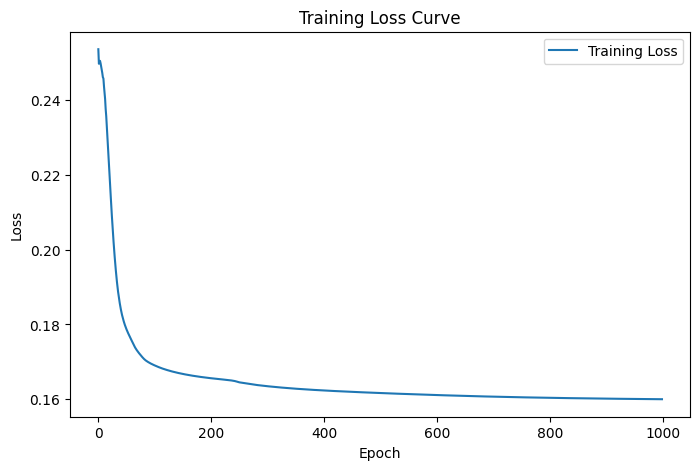

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

## Evaluating the Model

Let's take a few examples from our dataset and see what the network predicts before and after training. The output is a probability (close to 0 for non-symmetric and close to 1 for symmetric sequences).

In [ ]:
# Choose a few random examples
indices = np.random.choice(len(X_tensor), size=5, replace=False)
sample_inputs = X_tensor[indices]
sample_labels = y_tensor[indices]

with torch.no_grad():
    sample_outputs = model(sample_inputs)

print('Input sequences:')
print(sample_inputs.numpy())
print('\nTrue labels:')
print(sample_labels.numpy())
print('\nPredicted probabilities:')
print(sample_outputs.numpy())

Input sequences:
[[6. 4. 6. 6. 4. 6.]
 [9. 4. 1. 8. 5. 2.]
 [3. 0. 7. 0. 4. 5.]
 [8. 7. 4. 4. 7. 8.]
 [2. 6. 2. 2. 9. 4.]]

True labels:
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]]

Predicted probabilities:
[[0.68117094]
 [0.00319485]
 [0.6820884 ]
 [0.6813711 ]
 [0.6820884 ]]


## Discussion

- **Backpropagation:** In each training iteration, the network computes how far off its prediction is (loss), and the gradients are calculated using backpropagation. These gradients indicate how each weight should change to reduce the loss.

- **Representation Learning:** As the network adjusts its weights, it develops internal representations in the hidden layer that help it detect the concept of symmetry even though it was never explicitly told what symmetry is. The hidden layer neurons begin to encode features that are important for the task.

- **The Obtained Results:** The results does not match the mentioned paper, since PyTorch use different implementation probably.